# PCA analysis of all EPs


--- Processing EP6 (2004–2009) ---
765 MEPs × 200 votes
✅ Saved figs_new/pca/EP6_(2004–2009).png

--- Processing EP7 (2009–2014) ---
753 MEPs × 200 votes
✅ Saved figs_new/pca/EP7_(2009–2014).png

--- Processing EP8 (2014–2019) ---
755 MEPs × 200 votes
✅ Saved figs_new/pca/EP8_(2014–2019).png

--- Processing EP9 (2019–2024) ---
701 MEPs × 200 votes
✅ Saved figs_new/pca/EP9_(2019–2024).png

--- Processing EP10 (2024–present) ---
718 MEPs × 200 votes
✅ Saved figs_new/pca/EP10_(2024–present).png


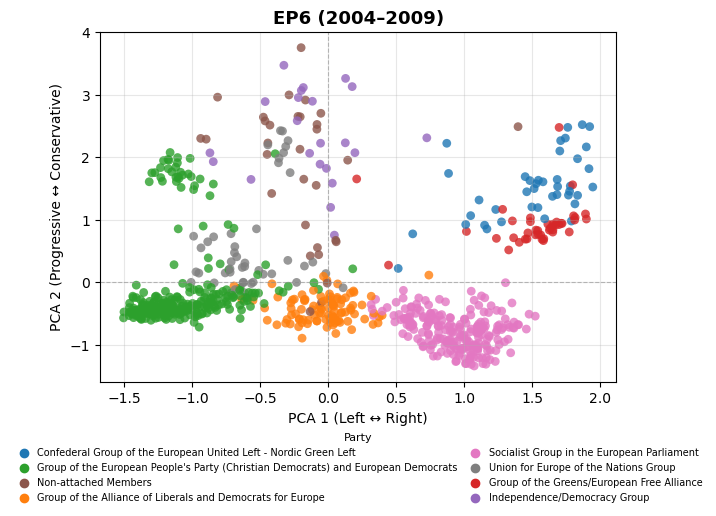

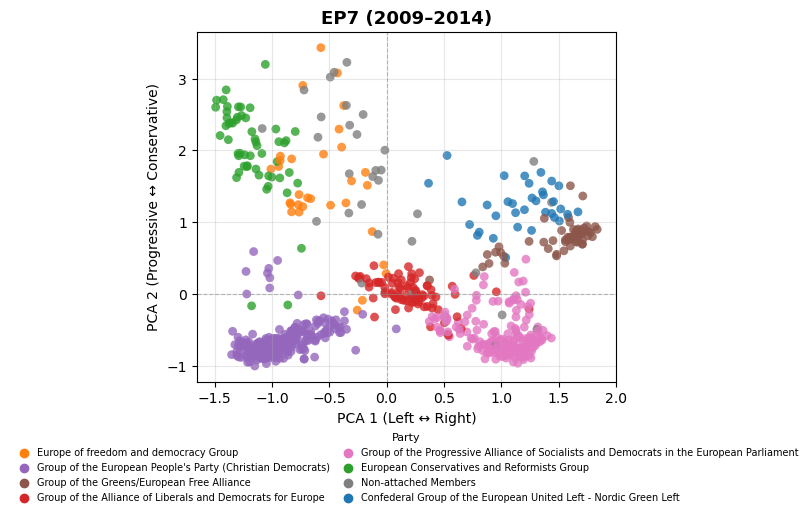

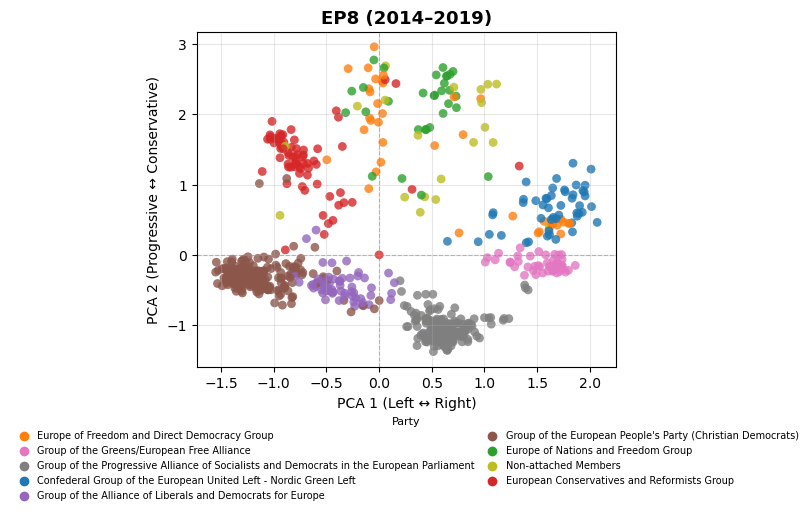

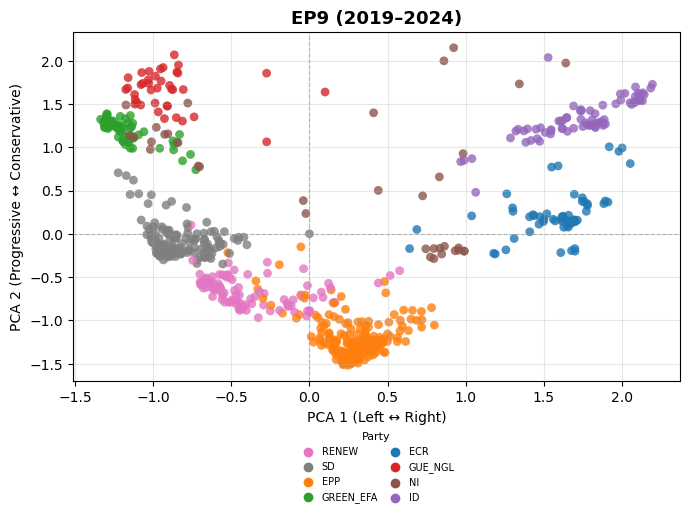

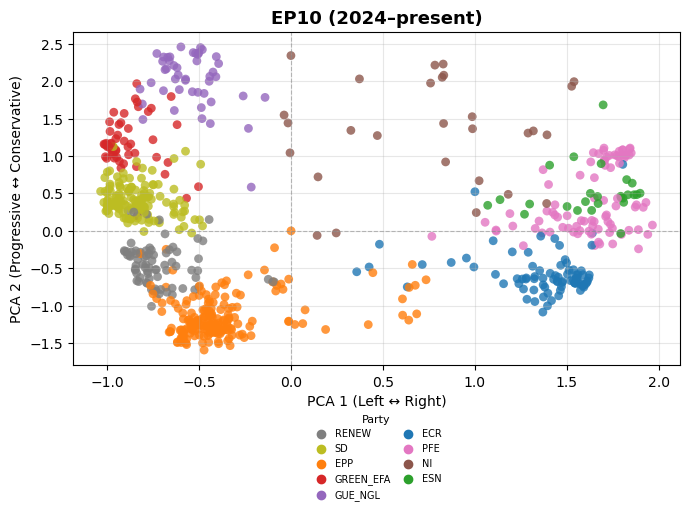

In [ ]:
# ============================================================
# European Parliament – Political Compass (Dynamic Multi-EP PCA)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from pathlib import Path

# ---------- Config ----------
EP_FILES = {
    "EP6 (2004–2009)": "data/all_votes_EP6.csv",
    "EP7 (2009–2014)": "data/all_votes_EP7.csv",
    "EP8 (2014–2019)": "data/all_votes_EP8.csv",
    "EP9 (2019–2024)": "data/all_votes_EP9.csv",
    "EP10 (2024–present)": "data/all_votes_EP10.csv",
}

OUTDIR = Path("figs/pca")
OUTDIR.mkdir(exist_ok=True, parents=True)


# ---------- Helper functions ----------
def load_votes(csv_path):
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)

    # vote cols are a subset of the columns randomly sampled
    vote_cols = [c for c in df.columns if c.isdigit()]
    vote_cols = np.random.choice(vote_cols, size=200, replace=False)

    # only keep MEPs with at least 50% of the votes
    df = df[df[vote_cols].notna().sum(axis=1) >= 0.5 * len(vote_cols)]

    # unify column name
    if "member.group.short_label" not in df.columns:
        # fallback: try to detect similar column
        matches = [c for c in df.columns if "group" in c.lower()]
        if matches:
            df["member.group.short_label"] = df[matches[0]]
        else:
            df["member.group.short_label"] = "Unknown"
    return df, vote_cols


def compute_pca_2d(df, vote_cols):
    """Compute 2D PCA ideological coordinates."""
    enc = {'FOR': 1.0, 'AGAINST': -1.0, 'ABSTENTION': 0.0, 'DID_NOT_VOTE': np.nan}
    M = df[vote_cols].replace(enc).astype(float)
    M = M - M.mean(axis=0)  # center
    M = M.fillna(0.0)

    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(M)
    df["_pc1"] = (comps[:, 0] - np.mean(comps[:, 0])) / (np.std(comps[:, 0]) + 1e-9)
    df["_pc2"] = (comps[:, 1] - np.mean(comps[:, 1])) / (np.std(comps[:, 1]) + 1e-9)
    return df, pca


def plot_pca(df, title, outpath):
    parties = sorted(df["member.group.short_label"].dropna().unique())
    palette = dict(zip(parties, sns.color_palette("tab10", n_colors=len(parties))))

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(
        data=df, x="_pc1", y="_pc2",
        hue="member.group.short_label", palette=palette,
        alpha=0.8, s=40, edgecolor="none", ax=ax
    )

    ax.set_title(title, fontsize=13, weight="bold")
    ax.set_xlabel("PCA 1 (Left ↔ Right)")
    ax.set_ylabel("PCA 2 (Progressive ↔ Conservative)")
    ax.axvline(0, color="gray", lw=0.8, ls="--", alpha=0.5)
    ax.axhline(0, color="gray", lw=0.8, ls="--", alpha=0.5)
    ax.grid(alpha=0.3)

    # --- Compact horizontal legend below plot ---
    handles, labels = ax.get_legend_handles_labels()
    ncol = max(2, len(labels) // 4)  # adaptively choose number of columns
    ax.legend(
        handles=handles, labels=labels,
        title="Party", loc="upper center",
        bbox_to_anchor=(0.5, -0.12),
        ncol=ncol, fontsize=7, title_fontsize=8,
        frameon=False, handletextpad=0.4, columnspacing=0.8
    )

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    print(f"✅ Saved {outpath}")


# ---------- Run PCA for each legislature ----------
for ep_name, path in EP_FILES.items():
    print(f"\n--- Processing {ep_name} ---")
    df, vote_cols = load_votes(path)
    print(f"{len(df)} MEPs × {len(vote_cols)} votes")

    df, _ = compute_pca_2d(df, vote_cols)
    plot_pca(df, ep_name, OUTDIR / f"{ep_name.replace(' ', '_')}.png")

/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_4418/4147810830.py:64: RuntimeWarning: Mean of empty slice
  col_mean = np.nanmean(M_all, axis=0, keepdims=True)


✅ Trained global PCA on union | n_features = 32228
✅ Saved figs_new/pca_joint/EP6_(2004–2009)_globalPCA.png
✅ Saved figs_new/pca_joint/EP7_(2009–2014)_globalPCA.png
✅ Saved figs_new/pca_joint/EP8_(2014–2019)_globalPCA.png
✅ Saved figs_new/pca_joint/EP9_(2019–2024)_globalPCA.png
✅ Saved figs_new/pca_joint/EP10_(2024–present)_globalPCA.png


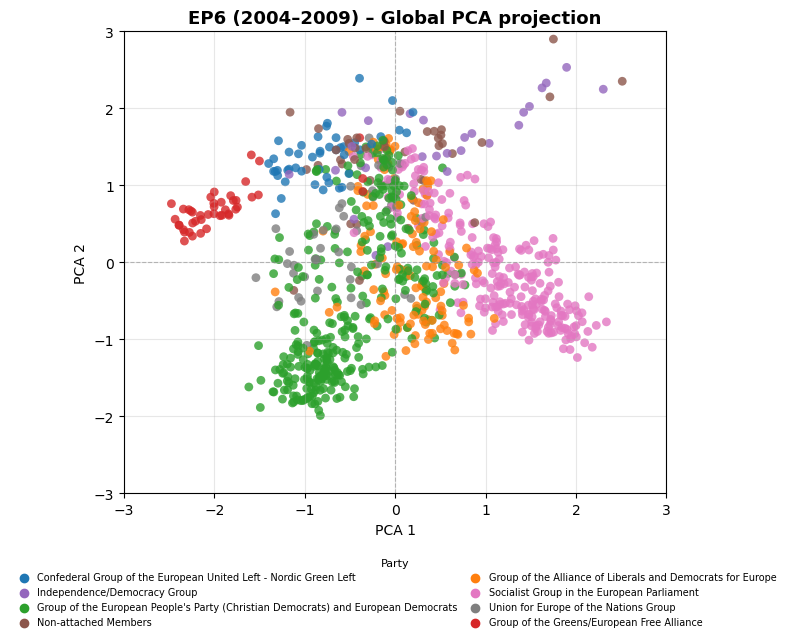

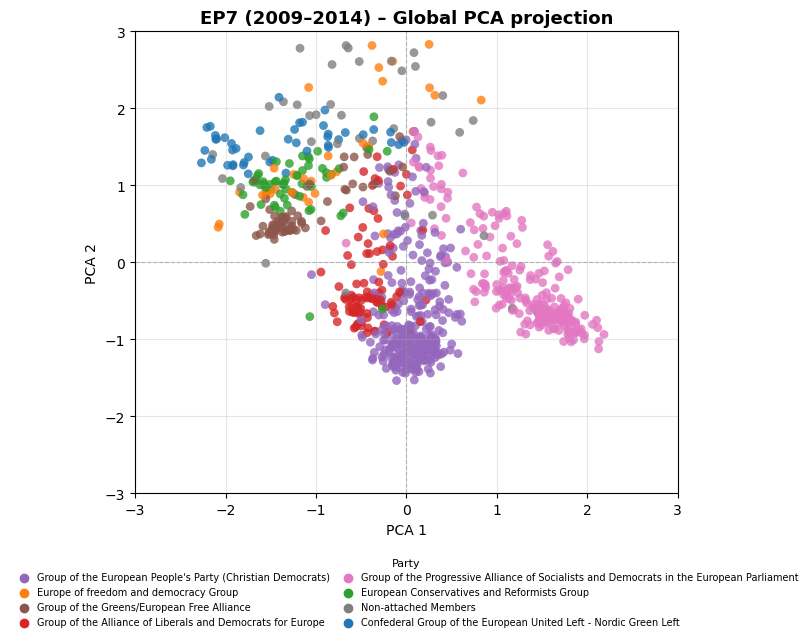

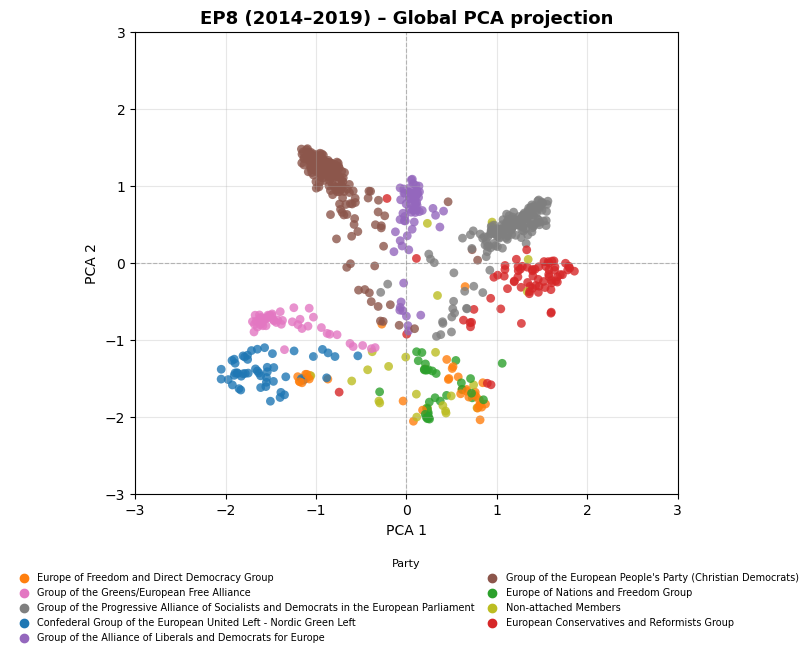

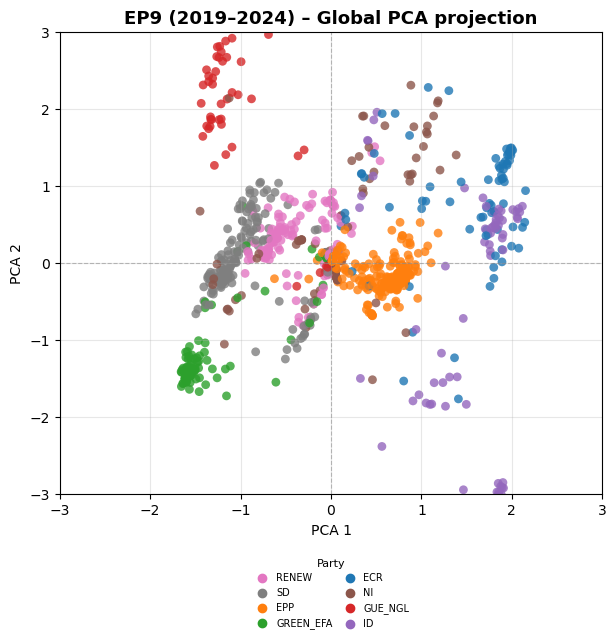

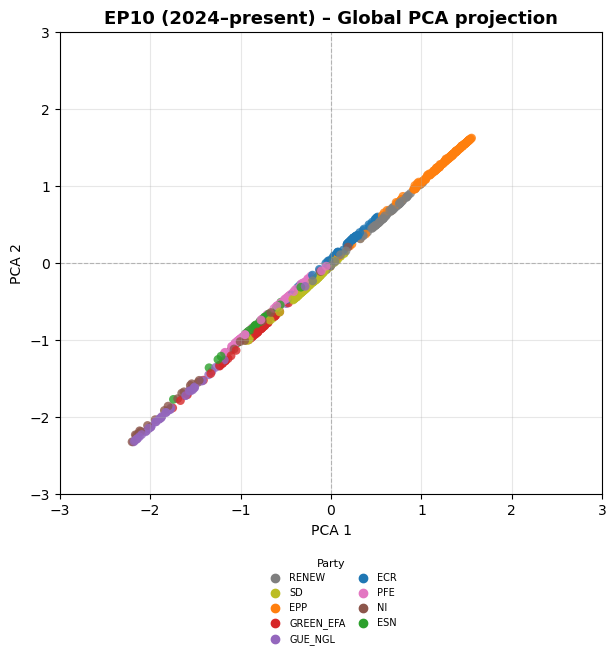

In [6]:
# ============================================================
# Global PCA (EP6–EP10) and per-legislature projections on same axes
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

# ---- Config ----
EP_FILES = {
    "EP6 (2004–2009)": "data/all_votes_EP6.csv",
    "EP7 (2009–2014)": "data/all_votes_EP7.csv",
    "EP8 (2014–2019)": "data/all_votes_EP8.csv",
    "EP9 (2019–2024)": "data/all_votes_EP9.csv",
    "EP10 (2024–present)": "data/all_votes_EP10.csv",
}
OUTDIR = Path("figs_new/pca_joint")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---- Helpers ----
def load_votes_str(csv_path: str) -> tuple[pd.DataFrame, list[str]]:
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)
    df.columns = df.columns.astype(str).str.strip()
    vote_cols = [c for c in df.columns if c.isdigit()]
    if "member.group.short_label" not in df.columns:
        # fallback if party col differs
        candidates = [c for c in df.columns if "group" in c.lower()]
        if candidates:
            df["member.group.short_label"] = df[candidates[0]]
        else:
            df["member.group.short_label"] = "Unknown"
    return df, vote_cols

ENC_MAP = {
    "FOR": 1.0,
    "AGAINST": -1.0,
    "ABSTENTION": 0.0,
    "DID_NOT_VOTE": np.nan,
}

def encode_matrix(df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    return df[cols].replace(ENC_MAP).to_numpy(dtype=float)

# ---- Build global feature set ----
frames: list[pd.DataFrame] = []
all_cols: set[str] = set()
for label, path in EP_FILES.items():
    df_i, cols_i = load_votes_str(path)
    df_i["_Period"] = label
    frames.append(df_i)
    all_cols.update(cols_i)

all_vote_cols = [str(c) for c in sorted(all_cols)]

df_all = pd.concat(frames, ignore_index=True)
meta_cols = [c for c in df_all.columns if not c.isdigit()]
df_all = df_all.reindex(columns=meta_cols + all_vote_cols, fill_value=np.nan)

# ---- Global PCA ----
M_all = encode_matrix(df_all, all_vote_cols)
col_mean = np.nanmean(M_all, axis=0, keepdims=True)
M_all_centered = np.nan_to_num(M_all - col_mean)

pca_global = PCA(n_components=2, random_state=42)
pca_global.fit(M_all_centered)
print(f"✅ Trained global PCA on union | n_features = {M_all_centered.shape[1]}")

# ---- Project each legislature on same PCA and same axes ----
results: dict[str, pd.DataFrame] = {}
coords_all = []
for label, path in EP_FILES.items():
    df_i, cols_i = load_votes_str(path)
    aligned = df_i.reindex(columns=all_vote_cols, fill_value=np.nan)
    M_i = encode_matrix(aligned, all_vote_cols)
    M_i_centered = np.nan_to_num(M_i - col_mean)
    coords_i = pca_global.transform(M_i_centered)
    df_i["_pc1"] = (coords_i[:, 0] - np.mean(coords_i[:, 0])) / (np.std(coords_i[:, 0]) + 1e-9)
    df_i["_pc2"] = (coords_i[:, 1] - np.mean(coords_i[:, 1])) / (np.std(coords_i[:, 1]) + 1e-9)
    results[label] = df_i
    coords_all.append(coords_i)

coords_all = np.vstack(coords_all)
# ---- Plot each legislature separately but on same axes ----
for label, df_i in results.items():
    parties = sorted(df_i["member.group.short_label"].dropna().unique())
    palette = dict(zip(parties, sns.color_palette("tab10", n_colors=len(parties))))

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(
        data=df_i, x="_pc1", y="_pc2",
        hue="member.group.short_label", palette=palette,
        alpha=0.8, s=40, edgecolor="none", ax=ax
    )
    ax.set_title(f"{label} – Global PCA projection", fontsize=13, weight="bold")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.axvline(0, color="gray", lw=0.8, ls="--", alpha=0.5)
    ax.axhline(0, color="gray", lw=0.8, ls="--", alpha=0.5)
    xlim = (-3, 3)
    ylim = (-3, 3)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.3)

    handles, labels = ax.get_legend_handles_labels()
    ncol = max(2, len(labels) // 4) if labels else 2
    ax.legend(
        handles=handles, labels=labels,
        title="Party", loc="upper center",
        bbox_to_anchor=(0.5, -0.12), ncol=ncol, fontsize=7, title_fontsize=8,
        frameon=False, handletextpad=0.4, columnspacing=0.8
    )

    out = OUTDIR / f"{label.replace(' ', '_')}_globalPCA.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    print(f"✅ Saved {out}")


Selected 1253 votes of type: 1.0
Found 1253 matching vote columns


/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_11595/3986291634.py:42: RuntimeWarning: Mean of empty slice
  M = np.nan_to_num(M - np.nanmean(M, axis=0, keepdims=True))


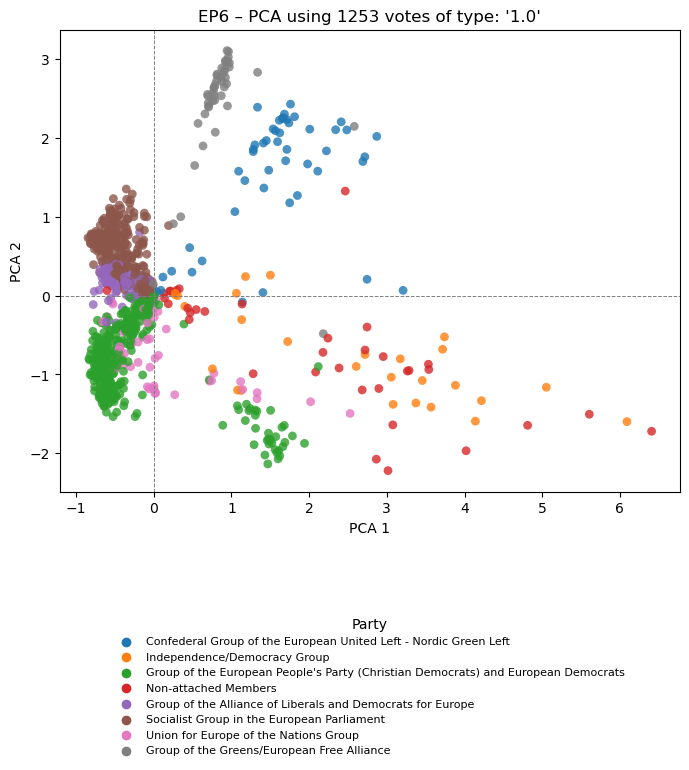

Selected 1664 votes of type: 1.0
Found 1664 matching vote columns


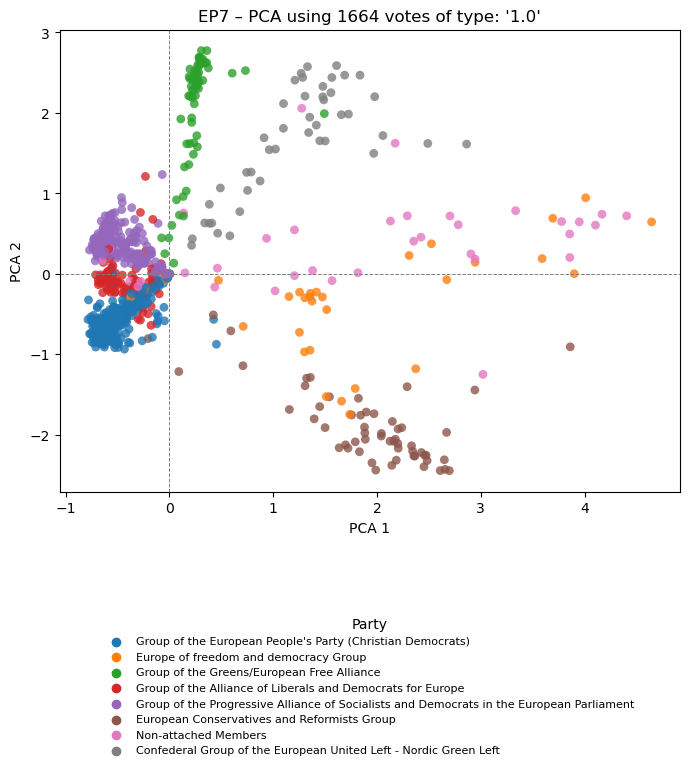

Selected 2072 votes of type: 1.0
Found 2072 matching vote columns


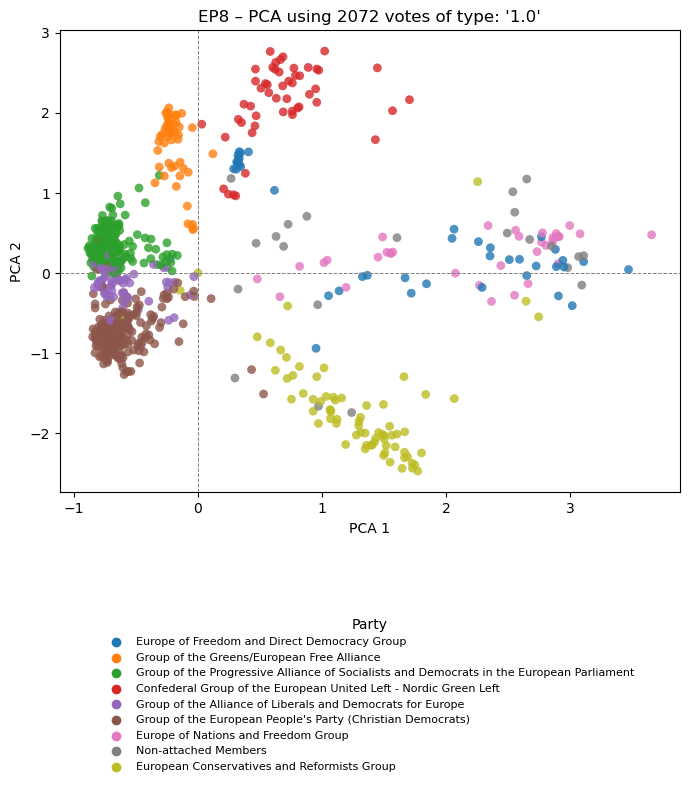

Selected 2098 votes of type: True
Found 1805 matching vote columns


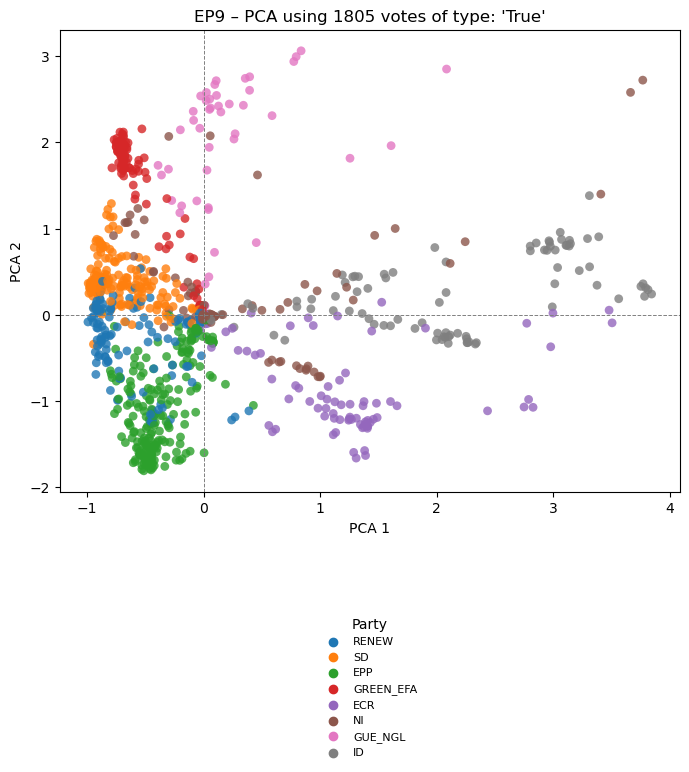

Selected 2098 votes of type: True
Found 291 matching vote columns


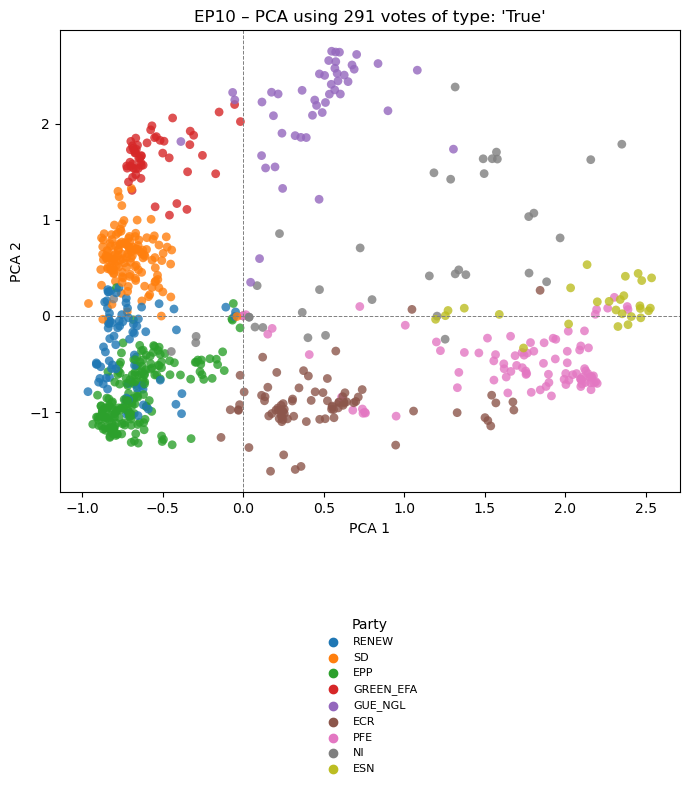

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path("data/votewatch_csv")

def plot_pca_votewatch(EP, TARGET_TYPE, id):
    # --- Load metadata (vote descriptions) ---
    elif EP == "EP9" or EP == "EP10":
        meta_path = "data/votes_htv_df.csv"
        meta = pd.read_csv(meta_path)
        selected_votes = meta.loc[
            meta["is_main"] == TARGET_TYPE, id
        ].astype(str).tolist()
    else:
        meta_path = DATA_DIR / f"{EP}_Voted docs.csv"
        meta = pd.read_csv(meta_path)
        # subject = "subject" if EP == "EP6" else "Subject" # this works for "Subject" column
        subject = "final_vote" if EP == "EP6" else "Final vote?"
        # selected_votes = meta.loc[meta[subject].str.strip().str.lower() == TARGET_TYPE.lower(), id].astype(str).tolist() # this works for "Subject" column
        selected_votes = meta.loc[meta[subject] == TARGET_TYPE, id].astype(str).tolist() # this works for "Final vote?" column

    print(f"Selected {len(selected_votes)} votes of type: {TARGET_TYPE}")

    # --- Load main voting matrix ---
    votes_path = f"data/all_votes_{EP}.csv"
    df = pd.read_csv(votes_path, dtype=str)

    vote_cols = [c for c in df.columns if c.isdigit()]
    vote_cols_filtered = [c for c in vote_cols if c in selected_votes]
    print(f"Found {len(vote_cols_filtered)} matching vote columns")

    if len(vote_cols_filtered) < 50:
        print("⚠️ Few votes match this filter — consider broadening criteria")

    # --- Encode votes numerically ---
    encode = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': np.nan}
    M = df[vote_cols_filtered].replace(encode).to_numpy(float)
    M = np.nan_to_num(M - np.nanmean(M, axis=0, keepdims=True))

    # --- PCA ---
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(M)
    df["_pc1"], df["_pc2"] = coords[:, 0], coords[:, 1]

    # --- Normalize ---
    df["_pc1"] = (df["_pc1"] - df["_pc1"].mean()) / (df["_pc1"].std() + 1e-9)
    df["_pc2"] = (df["_pc2"] - df["_pc2"].mean()) / (df["_pc2"].std() + 1e-9)

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(
        data=df,
        x="_pc1",
        y="_pc2",
        hue="member.group.short_label",
        palette="tab10",
        s=40,
        alpha=0.8,
        edgecolor="none",
    )

    plt.axvline(0, color="gray", lw=0.7, ls="--")
    plt.axhline(0, color="gray", lw=0.7, ls="--")

    plt.title(f"{EP} – PCA using {len(vote_cols_filtered)} votes of type: '{TARGET_TYPE}'")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

    # --- Legend below the plot ---
    # --- Legend below the plot (vertical layout) ---
    ax.legend(
        title="Party",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.25),  # move further down if needed
        ncol=1,                       # vertical layout (1 column)
        fontsize=8,
        frameon=False
    )

    plt.show()

# this snippet works for "Subject" column
# plot_pca_votewatch("EP6", "vote: resolution (as a whole)", "euro_act_id")
# plot_pca_votewatch("EP7", "vote: resolution (text as a whole)", "Vote ID")
# plot_pca_votewatch("EP8", "vote: resolution", "Vote ID")
# plot_pca_votewatch("EP9", True, "id")
# plot_pca_votewatch("EP10", True, "id")

plot_pca_votewatch("EP6", 1.0, "euro_act_id")
plot_pca_votewatch("EP7", 1.0, "Vote ID")
plot_pca_votewatch("EP8", 1.0, "Vote ID")
plot_pca_votewatch("EP9", True, "id")
plot_pca_votewatch("EP10", True, "id")

Selected 5666 votes of type: not vote: resolution (as a whole)
Found 5666 matching vote columns


/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_40791/3209230493.py:38: RuntimeWarning: Mean of empty slice
  M = np.nan_to_num(M - np.nanmean(M, axis=0, keepdims=True))


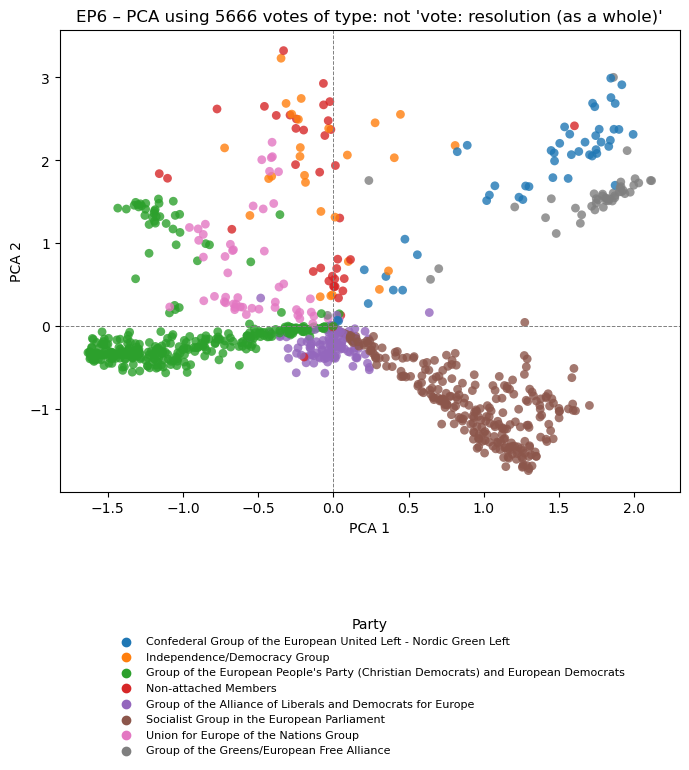

Selected 6676 votes of type: not vote: resolution (text as a whole)
Found 6676 matching vote columns


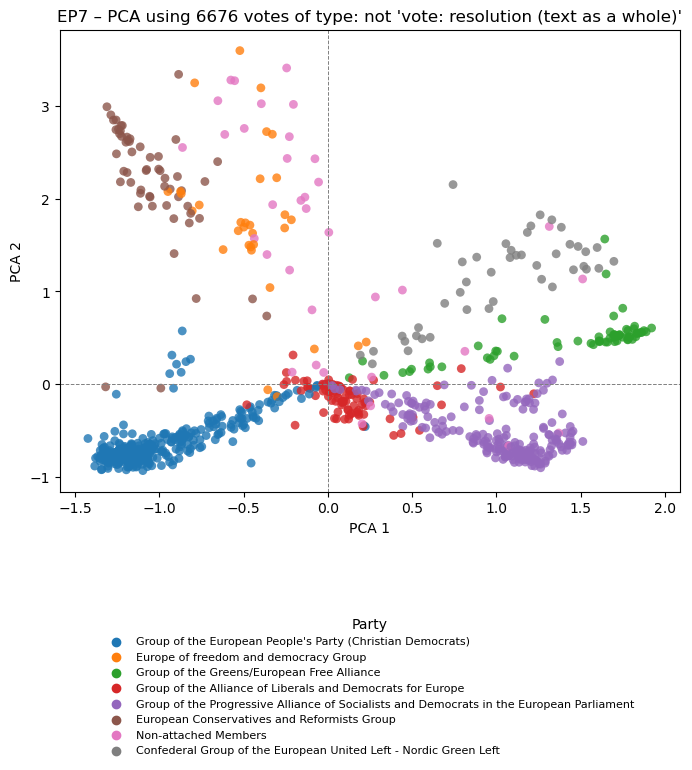

Selected 9623 votes of type: not vote: resolution
Found 9623 matching vote columns


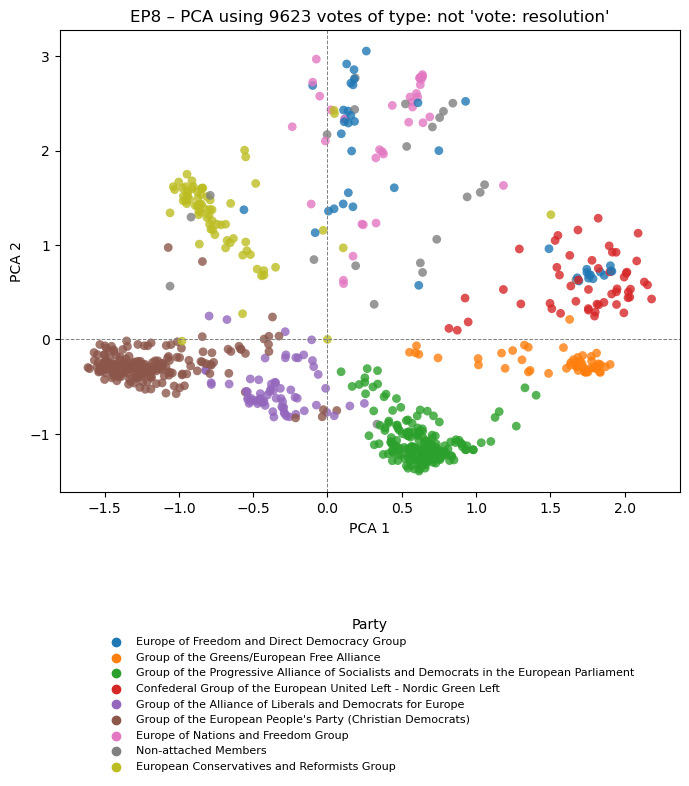

Selected 19860 votes of type: not True
Found 17467 matching vote columns


/var/folders/wd/y6168jtx54j31_3xpbpm3srr0000gn/T/ipykernel_40791/3209230493.py:38: RuntimeWarning: Mean of empty slice
  M = np.nan_to_num(M - np.nanmean(M, axis=0, keepdims=True))


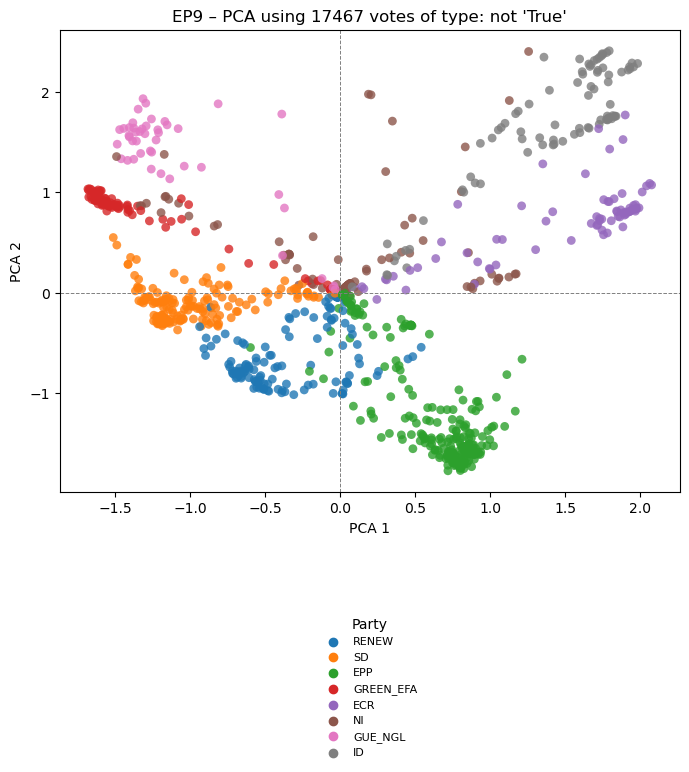

Selected 19860 votes of type: not True
Found 2390 matching vote columns


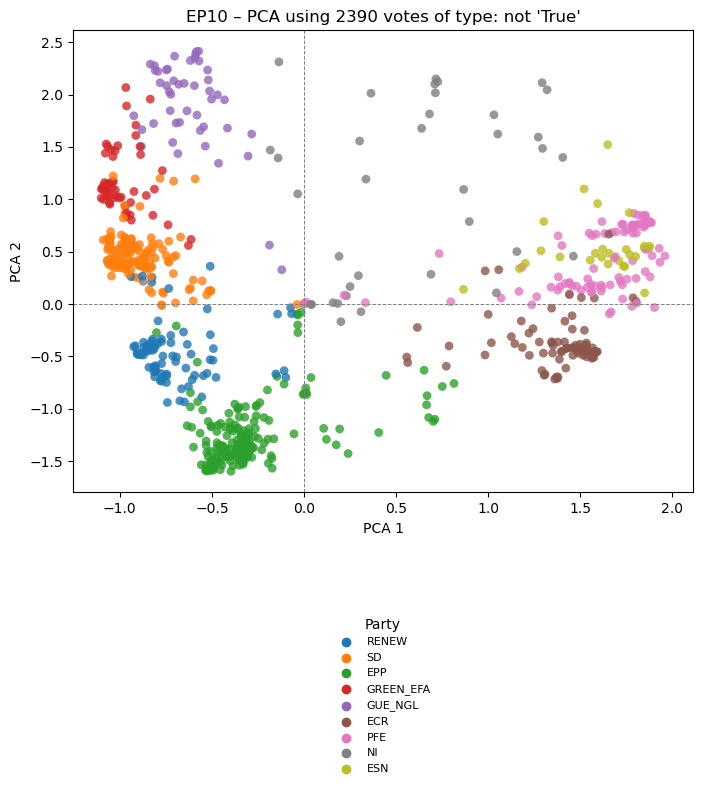

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def plot_pca_votewatch(EP, TARGET_TYPE, id):
    # --- Load metadata (vote descriptions) ---
    if EP == "EP9" or EP == "EP10":
        meta_path = "data/votes_htv_df.csv"
        meta = pd.read_csv(meta_path)
        selected_votes = meta.loc[
            meta["is_main"] != TARGET_TYPE, id
        ].astype(str).tolist()
    else:
        meta_path = DATA_DIR / f"{EP}_Voted docs.csv"
        meta = pd.read_csv(meta_path)
        subject = "subject" if EP == "EP6" else "Subject"
        selected_votes = meta.loc[meta[subject].str.strip().str.lower() != TARGET_TYPE.lower(), id].astype(str).tolist()

    print(f"Selected {len(selected_votes)} votes of type: not {TARGET_TYPE}")

    # --- Load main voting matrix ---
    votes_path = f"data/all_votes_{EP}.csv"
    df = pd.read_csv(votes_path, dtype=str)

    vote_cols = [c for c in df.columns if c.isdigit()]
    vote_cols_filtered = [c for c in vote_cols if c in selected_votes]
    print(f"Found {len(vote_cols_filtered)} matching vote columns")

    if len(vote_cols_filtered) < 50:
        print("⚠️ Few votes match this filter — consider broadening criteria")

    # --- Encode votes numerically ---
    encode = {'FOR': 1, 'AGAINST': -1, 'ABSTENTION': 0, 'DID_NOT_VOTE': np.nan}
    M = df[vote_cols_filtered].replace(encode).to_numpy(float)
    M = np.nan_to_num(M - np.nanmean(M, axis=0, keepdims=True))

    # --- PCA ---
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(M)
    df["_pc1"], df["_pc2"] = coords[:, 0], coords[:, 1]

    # --- Normalize ---
    df["_pc1"] = (df["_pc1"] - df["_pc1"].mean()) / (df["_pc1"].std() + 1e-9)
    df["_pc2"] = (df["_pc2"] - df["_pc2"].mean()) / (df["_pc2"].std() + 1e-9)

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    ax = sns.scatterplot(
        data=df,
        x="_pc1",
        y="_pc2",
        hue="member.group.short_label",
        palette="tab10",
        s=40,
        alpha=0.8,
        edgecolor="none",
    )

    plt.axvline(0, color="gray", lw=0.7, ls="--")
    plt.axhline(0, color="gray", lw=0.7, ls="--")

    plt.title(f"{EP} – PCA using {len(vote_cols_filtered)} votes of type: not '{TARGET_TYPE}'")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

    # --- Legend below the plot ---
    # --- Legend below the plot (vertical layout) ---
    ax.legend(
        title="Party",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.25),  # move further down if needed
        ncol=1,                       # vertical layout (1 column)
        fontsize=8,
        frameon=False
    )

    plt.show()


plot_pca_votewatch("EP6", "vote: resolution (as a whole)", "euro_act_id")
plot_pca_votewatch("EP7", "vote: resolution (text as a whole)", "Vote ID")
plot_pca_votewatch("EP8", "vote: resolution", "Vote ID")
plot_pca_votewatch("EP9", True, "id")
plot_pca_votewatch("EP10", True, "id")

In [7]:
# ============================================================
# Global PCA on Main Vote Resolutions for EP6-EP10
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from joblib import Parallel, delayed

# ---- Config ----
EP_FILES = {
    "EP6 (2004–2009)": "data/all_votes_EP6.csv",
    "EP7 (2009–2014)": "data/all_votes_EP7.csv",
    "EP8 (2014–2019)": "data/all_votes_EP8.csv",
    "EP9 (2019–2024)": "data/all_votes_EP9.csv",
    "EP10 (2024–present)": "data/all_votes_EP10.csv",
}

# Metadata files with vote type info
EP_METADATA = {
    "EP6": {
        "path": "data/votewatch_csv/EP6_Voted docs.csv",
        "vote_col": "euro_act_id",
        "type_col": "subject",
        "main_values": ["vote: resolution (as a whole)", "vote: resolution", "vote: resolution (text as a whole)"]
    },
    "EP7": {
        "path": "data/votewatch_csv/EP7_Voted docs.csv",
        "vote_col": "Vote ID",
        "type_col": "Subject",
        "main_values": ["vote: resolution (as a whole)", "vote: resolution", "vote: resolution (text as a whole)"]
    },
    "EP8": {
        "path": "data/votewatch_csv/EP8_Voted docs.csv",
        "vote_col": "Vote ID",
        "type_col": "Subject",
        "main_values": ["vote: resolution (as a whole)", "vote: resolution", "vote: resolution (text as a whole)"]
    },
    "EP9": {
        "path": "data/votes_htv_df.csv",
        "vote_col": "id",
        "type_col": "is_main",
        "main_values": [True, 1, "True"]
    },
    "EP10": {
        "path": "data/votes_htv_df.csv",
        "vote_col": "id",
        "type_col": "is_main",
        "main_values": [True, 1, "True"]
    }
}

OUTDIR = Path("figs_new/pca_main_votes")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---- Helpers ----
ENC_MAP = {
    "FOR": 1.0,
    "AGAINST": -1.0,
    "ABSTENTION": 0.0,
    "DID_NOT_VOTE": np.nan,
    "DID NOT VOTE": np.nan,
}

def load_votes_str(csv_path: str) -> tuple[pd.DataFrame, list[str]]:
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)
    df.columns = df.columns.astype(str).str.strip()
    vote_cols = [c for c in df.columns if c.isdigit()]
    if "member.group.short_label" not in df.columns:
        candidates = [c for c in df.columns if "group" in c.lower()]
        if candidates:
            df["member.group.short_label"] = df[candidates[0]]
        else:
            df["member.group.short_label"] = "Unknown"
    return df, vote_cols

def encode_matrix(df: pd.DataFrame, cols: list[str]) -> np.ndarray:
    return df[cols].replace(ENC_MAP).to_numpy(dtype=float)

def filter_main_votes(df_votes: pd.DataFrame, ep_label: str) -> pd.DataFrame:
    """Filter votes to keep only main resolutions."""
    ep_name = ep_label.split()[0]  # Extract "EP6", "EP7", etc.
    
    if ep_name not in EP_METADATA:
        print(f"No metadata config for {ep_name}, returning all votes")
        return df_votes
    
    meta_config = EP_METADATA[ep_name]
    meta_path = meta_config["path"]
    vote_col = meta_config["vote_col"]
    type_col = meta_config["type_col"]
    main_values = meta_config["main_values"]
    
    # Load metadata
    try:
        meta = pd.read_csv(meta_path)
        # Normalize column names
        meta.columns = meta.columns.str.strip()
        
        # Filter for main votes
        mask = meta[type_col].isin(main_values)
        main_vote_ids = meta.loc[mask, vote_col].astype(str).tolist()
        
        # Keep only vote columns that are in the main vote IDs
        vote_cols = [c for c in df_votes.columns if c.isdigit()]
        main_vote_cols = [c for c in vote_cols if c in main_vote_ids]
        
        print(f"{ep_name}: {len(main_vote_cols)} main votes out of {len(vote_cols)} total")
        
        # Return filtered DataFrame with metadata columns + main vote columns
        meta_cols = [c for c in df_votes.columns if not c.isdigit()]
        return df_votes[meta_cols + main_vote_cols]
        
    except Exception as e:
        print(f"Error filtering main votes for {ep_name}: {e}")
        return df_votes

# ---- Build global feature set with main votes only ----
# Subsampling controls for HPC-like speed
MAX_MEPS_PER_SET = 600      # subsample rows per legislature (None for all)
MAX_VOTES_GLOBAL = 8000     # subsample union of vote columns (None for all)
RANDOM_STATE = 42
frames: list[pd.DataFrame] = []
all_cols: set[str] = set()

for label, path in EP_FILES.items():
    df_i, cols_i = load_votes_str(path)
    df_i = filter_main_votes(df_i, label)
    
    # Optional row subsample (MEPs)
    if MAX_MEPS_PER_SET is not None and len(df_i) > MAX_MEPS_PER_SET:
        df_i = df_i.sample(n=MAX_MEPS_PER_SET, random_state=RANDOM_STATE)
    
    # Update vote columns after filtering
    cols_i = [c for c in df_i.columns if c.isdigit()]
    df_i["_Period"] = label
    frames.append(df_i)
    all_cols.update(cols_i)

all_vote_cols = [str(c) for c in sorted(all_cols)]

# Optional column subsample (global vote columns)
if MAX_VOTES_GLOBAL is not None and len(all_vote_cols) > MAX_VOTES_GLOBAL:
    rng = np.random.default_rng(RANDOM_STATE)
    all_vote_cols = list(rng.choice(all_vote_cols, size=MAX_VOTES_GLOBAL, replace=False))
    all_vote_cols.sort()

print(f"\nTotal main vote columns across all legislatures (after subsample): {len(all_vote_cols)}")

df_all = pd.concat(frames, ignore_index=True)
meta_cols = [c for c in df_all.columns if not c.isdigit()]
df_all = df_all.reindex(columns=meta_cols + all_vote_cols, fill_value=np.nan)

# ---- Global PCA on main votes ----
M_all = encode_matrix(df_all, all_vote_cols).astype(np.float32)
col_mean = np.nanmean(M_all, axis=0, keepdims=True).astype(np.float32)
M_all_centered = np.nan_to_num(M_all - col_mean)

# randomized SVD for speed
U_, S_, Vt_ = randomized_svd(M_all_centered, n_components=2, random_state=RANDOM_STATE)
class PCA2:
    def __init__(self, Vt):
        self.components_ = Vt
    def transform(self, X):
        return X @ self.components_.T
pca_global = PCA2(Vt_)

print(f"✅ Trained global PCA on main votes | n_features = {M_all_centered.shape[1]}")

# ---- Project each legislature on same PCA and same axes ----
results: dict[str, pd.DataFrame] = {}
coords_all = []

for label, path in EP_FILES.items():
    df_i, cols_i = load_votes_str(path)
    df_i = filter_main_votes(df_i, label)
    cols_i = [c for c in df_i.columns if c.isdigit()]
    
    aligned = df_i.reindex(columns=all_vote_cols, fill_value=np.nan)
    M_i = encode_matrix(aligned, all_vote_cols)
    M_i_centered = np.nan_to_num(M_i - col_mean)
    coords_i = pca_global.transform(M_i_centered)
    
    df_i["_pc1"] = (coords_i[:, 0] - np.mean(coords_i[:, 0])) / (np.std(coords_i[:, 0]) + 1e-9)
    df_i["_pc2"] = (coords_i[:, 1] - np.mean(coords_i[:, 1])) / (np.std(coords_i[:, 1]) + 1e-9)
    results[label] = df_i
    coords_all.append(coords_i)

coords_all = np.vstack(coords_all)
xlim = (np.percentile(coords_all[:, 0], 1), np.percentile(coords_all[:, 0], 99))
ylim = (np.percentile(coords_all[:, 1], 1), np.percentile(coords_all[:, 1], 99))


EP6: 284 main votes out of 6199 total
EP7: 227 main votes out of 6961 total
EP8: 973 main votes out of 10252 total
EP9: 1805 main votes out of 19272 total
EP10: 291 main votes out of 2681 total

Total main vote columns across all legislatures (after subsample): 3535
✅ Trained global PCA on main votes | n_features = 3535
EP6: 284 main votes out of 6199 total
EP7: 227 main votes out of 6961 total
EP8: 973 main votes out of 10252 total
EP9: 1805 main votes out of 19272 total
EP10: 291 main votes out of 2681 total


In [60]:
# ---- Plot each legislature separately but on same axes ----
for label, df_i in results.items():
    parties = sorted(df_i["member.group.short_label"].dropna().unique())
    palette = dict(zip(parties, sns.color_palette("tab10", n_colors=len(parties))))

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(
        data=df_i, x="_pc1", y="_pc2",
        hue="member.group.short_label", palette=palette,
        alpha=0.8, s=40, edgecolor="none", ax=ax
    )
    ax.set_title(f"{label} – Global PCA (Main Votes Only)", fontsize=13, weight="bold")
    ax.set_xlabel("PCA 1 (Left ↔ Right)")
    ax.set_ylabel("PCA 2 (Progressive ↔ Conservative)")
    ax.axvline(0, color="gray", lw=0.8, ls="--", alpha=0.5)
    ax.axhline(0, color="gray", lw=0.8, ls="--", alpha=0.5)
    xlim = (-3, 3)
    ylim = (-3, 3)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(alpha=0.3)

    handles, labels_leg = ax.get_legend_handles_labels()
    ncol = max(2, len(labels_leg) // 4) if labels_leg else 2
    ax.legend(
        handles=handles, labels=labels_leg,
        title="Party", loc="upper center",
        bbox_to_anchor=(0.5, -0.12), ncol=ncol, fontsize=7, title_fontsize=8,
        frameon=False, handletextpad=0.4, columnspacing=0.8
    )

    out = OUTDIR / f"{label.replace(' ', '_').replace('/', '_')}_mainVotes_globalPCA.png"
    fig.savefig(out, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"✅ Saved {out}")

print("\n✅ Global PCA on main votes complete!")

✅ Saved figs_new/pca_main_votes/EP6_(2004–2009)_mainVotes_globalPCA.png
✅ Saved figs_new/pca_main_votes/EP7_(2009–2014)_mainVotes_globalPCA.png
✅ Saved figs_new/pca_main_votes/EP8_(2014–2019)_mainVotes_globalPCA.png
✅ Saved figs_new/pca_main_votes/EP9_(2019–2024)_mainVotes_globalPCA.png
✅ Saved figs_new/pca_main_votes/EP10_(2024–present)_mainVotes_globalPCA.png

✅ Global PCA on main votes complete!


In [ ]:
# print the pca components
print(pca_global.components_)

[[-1.45080496e-11 -4.90089573e-11  2.30391701e-11 ... -1.68626983e-11
  -1.13282192e-11 -1.83606220e-11]
 [-2.78092790e-02 -5.05012031e-04  9.31797571e-05 ... -8.12683603e-03
   2.72150039e-03 -3.54598760e-02]]
